# Figure 1 - study area

This notebook shows the study area. <br />
&nbsp; a) The study location within Europe. <br />
&nbsp; b) The landcover in and surrounding the study area.

In [1]:
#### add data sources?

#### global import statements

In [64]:
from matplotlib import pyplot
%matplotlib inline
import pyproj
from matplotlib.patches import Rectangle

In [3]:
from os import path

In [4]:
from django.db import connection

In [5]:
from figutils import style, scalebars, query

#### set coordinate systems

In [6]:
austria_mgd = pyproj.Proj(init='epsg:31254')

#### variable definitions

In [7]:
figure_directory = "/Users/jake/OneDrive/Documents/alpine soundscapes/figures"

#### formating

In [8]:
style.set_font()

#### import statements

In [9]:
import rasterio
from geo.models import LandCoverType
from landscape.models import LandCoverTypeMap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import Greys
from matplotlib.lines import Line2D

from matplotlib.font_manager import FontProperties

In [10]:
import numpy
import pandas
from database.models import Site
from geo.models import SampleLocation, Boundary
from geo.models import Raster
import geopandas

In [11]:
boundary = query.get_geodataframe(Boundary.objects.filter(name__exact='study area'))
generated = query.get_geodataframe(SampleLocation.objects.all())
acutal = query.get_geodataframe(Site.objects.filter(id__lte=30))

In [12]:
area_percentages = pandas.read_csv("/Users/Jake/OneDrive/Documents/alpine soundscapes/data/landcover/area_percentages.csv").set_index('id')

osm roads data

In [13]:
#### TODO: write function to reduce text?

In [14]:
motorway_query = """SELECT * FROM public.geo_osm_roads_innsbruck WHERE type = 'motorway' OR type = 'motorway_link';"""
motorway = geopandas.read_postgis(sql=motorway_query, con=connection, 
                                  geom_col='geometry', crs=austria_mgd, index_col='gid')
primary_query = """SELECT * FROM public.geo_osm_roads_innsbruck WHERE type = 'primary' OR type = 'primary_link';"""
primary = geopandas.read_postgis(sql=primary_query, con=connection, 
                                  geom_col='geometry', crs=austria_mgd, index_col='gid')
secondary_query = """SELECT * FROM public.geo_osm_roads_innsbruck WHERE type = 'secondary' OR type = 'secondary_link';"""
secondary = geopandas.read_postgis(sql=secondary_query, con=connection, 
                                  geom_col='geometry', crs=austria_mgd, index_col='gid')
tertiary_query = """SELECT * FROM public.geo_osm_roads_innsbruck WHERE type = 'tertiary' OR type = 'tertiary_link';"""
tertiary = geopandas.read_postgis(sql=tertiary_query, con=connection, 
                                  geom_col='geometry', crs=austria_mgd, index_col='gid')
residential_query = """SELECT * FROM public.geo_osm_roads_innsbruck WHERE type = 'residential';"""
residential = geopandas.read_postgis(sql=residential_query, con=connection, 
                                  geom_col='geometry', crs=austria_mgd, index_col='gid')
unclassified_query = """SELECT * FROM public.geo_osm_roads_innsbruck WHERE type = 'unclassified';"""
unclassified = geopandas.read_postgis(sql=unclassified_query, con=connection, 
                                  geom_col='geometry', crs=austria_mgd, index_col='gid')

In [15]:
hillshade = Raster.objects.get(name='hillshade')
landcover = Raster.objects.get(name='landcover merged publication')

read raster data

In [16]:
with rasterio.open(path=hillshade.filepath, mode='r') as source:
    hillshade = {'data': source.read(1)}
    hillshade['extent'] = [source.bounds.left, source.bounds.right, source.bounds.bottom, source.bounds.top]
    source.close()
with rasterio.open(path=landcover.filepath, mode='r') as source:
    landcover = {'data': numpy.ma.masked_equal(source.read(1), value=source.nodata)}
    landcover['extent'] = [source.bounds.left, source.bounds.right, source.bounds.bottom, source.bounds.top]
    source.close()

## inset map

#### Import statements

In [17]:
from matplotlib import pyplot
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from imageio import imread

from urllib.request import urlretrieve
from zipfile import ZipFile
from os import path
from shutil import rmtree
from os import remove
from figutils import style

#### Variable declarations

Innsbruck coordinates

In [18]:
innsbruck_lon, innsbruck_lat = 11.3973, 47.2729

#### Download terrain data

In [19]:
terrain_url = r'http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/GRAY_50M_SR_W.zip'
filepath, message = urlretrieve(terrain_url, filename=path.basename(terrain_url))
terrain_zip = ZipFile(path.basename(terrain_url))
terrain_zip.extractall()

#### Read terrain data as image

In [20]:
in_hillshade = imread("./GRAY_50M_SR_W/GRAY_50M_SR_W.tif")
# makes oceans white
in_hillshade[in_hillshade == 106] = 255

#### Delete downloaded files

In [21]:
remove("./GRAY_50M_SR_W.zip")
rmtree("./GRAY_50M_SR_W/")

#### Figure

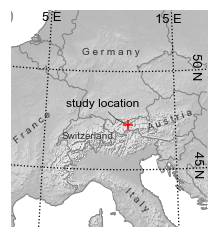

In [49]:
# define width and height of figure
height = (6.14 / 20) * 10
width = (6.85 / 20) * 8

# create figure
fig = pyplot.Figure()
fig.subplots_adjust(left=0, bottom=0, right=0.9, top=0.9, wspace=0, hspace=0)
fig.set_figheight(height)
fig.set_figwidth(width)
ax = pyplot.subplot(1, 1, 1, 
                    projection=ccrs.AlbersEqualArea(central_latitude=innsbruck_lat,
                                                    central_longitude=innsbruck_lon))

# create a feature for boundaries from Natural Earth Data
boundaries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='50m')
ax.add_feature(boundaries, edgecolor='gray', facecolor='none')

# add coastlines
#ax.set_extent([3, 17, 43, 52])
ax.set_extent([3, 17, 42, 53])
ax.coastlines(resolution='50m', color='gray')

# add gridlines
gl =  ax.gridlines(xlocs=range(-5, 35, 10), ylocs=range(40, 60, 5), 
             crs=ccrs.PlateCarree(), 
             linestyle=':',
             linewidth=1.25,
             color='black')

# add lat-lon labels
label_05E = ax.text(5, 52.7, '5 E', size=13, ha='center', va='center', transform=ccrs.Geodetic())
label_15E = ax.text(14.9, 52.7, '15 E ', size=13, ha='center', va='center', transform=ccrs.Geodetic())
label_50N = ax.text(16.75, 50.1, '50 N ', size=13, ha='center', va='center', rotation=270, transform=ccrs.Geodetic())
label_45N = ax.text(16.5, 45.2, '45 N', size=13, ha='center', va='center', rotation=270,  transform=ccrs.Geodetic())

# add terrain in_hillshade
in_hillshade_extent = [-180, 180, -90, 90]
ax.imshow(in_hillshade, extent=in_hillshade_extent, origin='upper', cmap='gray', alpha=0.5,
          transform=ccrs.PlateCarree())

# add study area point (Innsbruck)
ax.scatter(innsbruck_lon, innsbruck_lat, 100, color='red', marker='+',
            transform=ccrs.Geodetic(), zorder=10)

# add country labels
ax.outline_patch.set_visible(False)
label_austria = ax.text(14.6, 47.5, 'A u s t r i a', ha='center', va='center', rotation=20, transform=ccrs.Geodetic(), color='0.2', zorder=100)
label_germany = ax.text(10, 51, 'G e r m a n y', ha='center', va='center', transform=ccrs.Geodetic(), color='0.2')
label_france = ax.text(4.1, 47, 'F r a n c e', ha='center', va='center', rotation=40, transform=ccrs.Geodetic(), color='0.2')
label_italy = ax.text(12, 43.5, 'I t a l y', ha='center', va='center', rotation=315, transform=ccrs.Geodetic(), color='0.2')
label_switzerland = ax.text(8.25, 46.7, 'Switzerland', ha='center', va='center', transform=ccrs.Geodetic(), color='0.2', size=10)

ap = dict(arrowstyle='-', connectionstyle='arc3,rad=0.2', linewidth=0.5)
a1 = ax.annotate('study location', xy=(innsbruck_lon, innsbruck_lat), 
                 xytext=((innsbruck_lon - 150000), (innsbruck_lat + 125000)), 
                 ha='center', va='center', size=12, arrowprops=ap)

#### plot

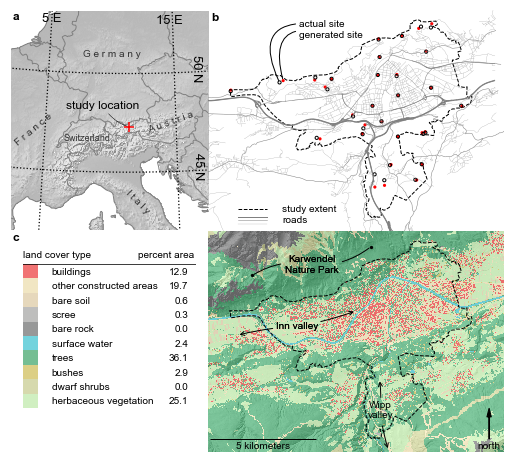

In [116]:
figure1 = pyplot.figure()
figure1.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

figure1.set_figheight(6.14)
figure1.set_figwidth(6.85)

# land cover
ax_a = pyplot.subplot2grid((40, 40), (20, 16), rowspan=20, colspan=24)

# land cover legend
ax_l = pyplot.subplot2grid((40, 40), (21, 1), rowspan=17, colspan=14)

# sites
ax_c = pyplot.subplot2grid((40, 40), (0, 16), rowspan=20, colspan=24, sharex=ax_a, sharey=ax_a)

# sites legend
#ax_cl = pyplot.subplot2grid((20, 20), (7, 0), rowspan=3, colspan=7, sharex=ax_l)

# inset (a)
ax_in = pyplot.subplot2grid((40, 40), (0, 0), rowspan=20, colspan=16,
                            projection=ccrs.AlbersEqualArea(central_latitude=innsbruck_lat,
                                                            central_longitude=innsbruck_lon))

# title formatting
title_font = {
    'size': 12.0,
    'weight': 'bold'
}

# formatting
ax_a.set_frame_on(False)
ax_a.tick_params(axis='both', 
                 bottom=False, right=False, top=False, left=False,
                 labelbottom=False, labelleft=False)

# landcover colormap
color_list = [t['color'] for t in LandCoverType.objects.all().order_by('id').values()]
landcover_colormap = LinearSegmentedColormap.from_list(name='landcover', colors=color_list)

# plot rasters
a_hillshade = ax_a.imshow('data', extent='extent', interpolation='none', data=hillshade, cmap='gray', alpha=0.5)
a_landcover = ax_a.imshow('data', extent='extent', interpolation='none', data=landcover, cmap=landcover_colormap, vmin=1, vmax=15, alpha=0.5)
a_boundary = boundary.plot(ax=ax_a, facecolor='none', edgecolor='black', linestyle='--', linewidth=1, label='study area')

# set plot limits
ax_a.set_xlim([72500, 86500])
ax_a.set_ylim([230500, 240500])

# title
ax_l.text(-0.06, 1.22, 'c', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font,
          transform=ax_l.transAxes)

#----- legend -----
type_array = numpy.array([1, 2, 3, 4, 5, 6, 9, 10, 11, 12]).reshape(10, 1)
type_array_background = numpy.ones(10).reshape(10, 1) * 0.5
ax_l.imshow(type_array_background, cmap='gray', vmin=0, vmax=1, interpolation='none', alpha=0.2)
ax_l.imshow(type_array, cmap=landcover_colormap, vmin=1, vmax=15, interpolation='none', alpha=0.5)
ax_l.set_xlim([-0.5, 11.5])

# formatting
ax_l.set_frame_on(False)
ax_l.set_aspect('equal')
ax_l.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)

# labels
for i, label in enumerate([r['name'] for r in LandCoverType.objects.filter(id__in=type_array).values()]):
    t0 = ax_l.text(1.5, i + 0.2, label.lower())
for i, a in enumerate(area_percentages['study_area'].iloc[type_array.ravel() - 1]):
    t1 = ax_l.text(11, i + 0.2, "{0:0.1f}".format(a), horizontalalignment='right')

#-----SITES
#-------------------------------------------------------
r0 = motorway.plot(ax=ax_c, color='gray', linewidth=1)
r1 = primary.plot(ax=ax_c, color='gray', linewidth=0.5)
r2 = secondary.plot(ax=ax_c, color='gray', linewidth=0.5)
r3 = tertiary.plot(ax=ax_c, color='gray', linewidth=0.2)
r4 = residential.plot(ax=ax_c, color='gray', linewidth=0.2)
r5 = unclassified.plot(ax=ax_c, color='gray', linewidth=0.2)
p0 = boundary.plot(ax=ax_c, facecolor='none', edgecolor='black', linestyle='--', linewidth=1)
p1 = generated.plot(ax=ax_c, color='red', marker='o', alpha=1, markersize=10, edgecolor='none')
p2 = acutal.plot(ax=ax_c, color='black', marker='o', markersize=10, facecolor='none')
p2 = acutal.plot(ax=ax_c, color='black', marker='+', markersize=20, facecolor='none')
ax_c.set_frame_on(False)
ax_c.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)
ax_c.text(0.01, 0.99, 'b', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font, 
          transform=ax_c.transAxes)

#-----SITES LEGEND
bbox_props = dict(boxstyle="round,pad=0.1", fc='none', ec='none')
p_a = acutal.loc[4].geometry
an = ax_c.annotate("actual site", xy=(p_a.x, p_a.y), xytext=(p_a.x + 900, p_a.y + 2750), xycoords=ax_c.transData,
               ha='left', va='center', bbox=bbox_props,
               arrowprops=dict(arrowstyle='-',
                               connectionstyle='arc3,rad=0.9'))
p_g = generated.loc[4].geometry
an = ax_c.annotate("generated site", xy=(p_g.x, p_g.y), xytext=(p_a.x + 900, p_a.y + 2250), xycoords=ax_c.transData,
               ha='left', va='center', bbox=bbox_props,
               arrowprops=dict(arrowstyle='-',
                               connectionstyle='arc3,rad=0.9'))

#----- legend -----
#ax_cl.tick_params(axis='both', 
#               bottom=False, right=False, top=False, left=False,
#               labelbottom=False, labelleft=False)
#ax_cl.set_frame_on(False)
#ax_cl.set_ylim([0, 1])
l3 = ax_c.plot([0.1, 0.2], [0.1, 0.1], color='black', markerfacecolor='none', markeredgecolor='black', linestyle='--', linewidth=1, transform=ax_c.transAxes)
l3 = ax_c.plot([0.1, 0.2], [0.065, 0.065], color='gray', markerfacecolor='none', markeredgecolor='black', linewidth=1, transform=ax_c.transAxes)
l3 = ax_c.plot([0.1, 0.2], [0.05, 0.05], color='gray', markerfacecolor='none', markeredgecolor='black', linewidth=0.5, transform=ax_c.transAxes)
l3 = ax_c.plot([0.1, 0.2], [0.035, 0.035], color='gray', markerfacecolor='none', markeredgecolor='black', linewidth=0.2, transform=ax_c.transAxes)
#l1 = ax_cl.plot(0.25, 0.5, color='red', marker='o', alpha=1, markersize=5, markeredgecolor='none')
#l2 = ax_cl.plot(0.25, 0.3, color='black', marker='o', markersize=5, markerfacecolor='none')
#l3 = ax_cl.plot(0.25, 0.3, color='black', marker='+', markersize=10, markerfacecolor='none')

t1 = ax_c.text(0.25, 0.1, 'study extent', va='center', transform=ax_c.transAxes)
t1 = ax_c.text(0.25, 0.05, 'roads', va='center', transform=ax_c.transAxes)
#t1 = ax_cl.text(1.5, 0.5, 'recording sites (generated)', va='center')
#t1 = ax_cl.text(1.5, 0.3, 'recording sites (actual)', va='center')

#-----------------------------------------------------
fp = FontProperties(size=10)
scale_bar = scalebars.add_scalebar(ax_a, matchx=False, matchy=False,
                         labely=None, sizey=None, labelx='5 kilometers', sizex=5000, loc=3, prop=fp)
dx = 0
dy = 0.1
arrow = ax_a.arrow(0.95, 0.06, dx, dy, fc="k", ec="k", linewidth = 1, head_width=0.015, head_length=0.04, transform=ax_a.transAxes)
north = ax_a.text(0.95, 0.01, 'north', ha='center', va='bottom', transform=ax_a.transAxes)

#---------------------------------------------------------------------------------------
#inset
# create a feature for boundaries from Natural Earth Data
boundaries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='50m')
ax_in.add_feature(boundaries, edgecolor='gray', facecolor='none')

# add coastlines
ax_in.set_extent([3, 17, 42, 53])
ax_in.coastlines(resolution='50m', color='gray')

# add gridlines
gl =  ax_in.gridlines(xlocs=range(-5, 35, 10), ylocs=range(40, 60, 5), 
             crs=ccrs.PlateCarree(), 
             linestyle=':',
             linewidth=1.25,
             color='black')

# add lat-lon labels
label_05E = ax_in.text(5, 52.7, '5 E', size=13, ha='center', va='center', transform=ccrs.Geodetic())
label_15E = ax_in.text(14.9, 52.7, '15 E ', size=13, ha='center', va='center', transform=ccrs.Geodetic())
label_50N = ax_in.text(16.75, 50.1, '50 N ', size=13, ha='center', va='center', rotation=270, transform=ccrs.Geodetic())
label_45N = ax_in.text(16.5, 45.2, '45 N', size=13, ha='center', va='center', rotation=270,  transform=ccrs.Geodetic())

# add terrain in_hillshade
in_hillshade_extent = [-180, 180, -90, 90]
ax_in.imshow(in_hillshade, extent=in_hillshade_extent, origin='upper', cmap='gray', alpha=0.5,
          transform=ccrs.PlateCarree())

# add study area point (Innsbruck)
ax_in.scatter(innsbruck_lon, innsbruck_lat, 100, color='red', marker='+',
            transform=ccrs.Geodetic(), zorder=10)

# add country labels
ax_in.outline_patch.set_visible(False)
label_austria = ax_in.text(14.6, 47.5, 'A u s t r i a', ha='center', va='center', rotation=20, transform=ccrs.Geodetic(), color='0.2', zorder=100)
label_germany = ax_in.text(10, 51, 'G e r m a n y', ha='center', va='center', transform=ccrs.Geodetic(), color='0.2')
label_france = ax_in.text(4.1, 47, 'F r a n c e', ha='center', va='center', rotation=40, transform=ccrs.Geodetic(), color='0.2')
label_italy = ax_in.text(12, 43.5, 'I t a l y', ha='center', va='center', rotation=315, transform=ccrs.Geodetic(), color='0.2')
label_switzerland = ax_in.text(8.25, 46.7, 'Switzerland', ha='center', va='center', transform=ccrs.Geodetic(), color='0.2', size=9)

ap = dict(arrowstyle='-', connectionstyle='arc3,rad=0.2', linewidth=0.5)
a1 = ax_in.annotate('study location', xy=(innsbruck_lon, innsbruck_lat), 
                 xytext=((innsbruck_lon - 150000), (innsbruck_lat + 125000)), 
                 ha='center', va='center', size=12, arrowprops=ap)

ax_in.text(0.01, 1, 'a', horizontalalignment='left', verticalalignment='top', fontdict=title_font, transform=ax_in.transAxes, zorder=11)
ax_in.set_frame_on(False)
ax_in.set_aspect('equal')
ax_in.tick_params(axis='both', 
                 bottom=False, right=False, top=False, left=False,
                 labelbottom=False, labelleft=False)

#wipeout
wout = Rectangle((0, 0.9), 0.1, 0.1, facecolor='white', edgecolor='white', alpha=1, zorder=10)
wout.set_transform(ax_in.transAxes)
ax_in.add_patch(wout)


# legend titles
lt1 = ax_l.text(0, 1.05, "land cover type", transform=ax_l.transAxes)
lt2 = ax_l.text(0.99, 1.05, "percent area", horizontalalignment='right', transform=ax_l.transAxes)
ll1 = ax_l.add_line(Line2D([0, 1], [1, 1], color='black', transform=ax_l.transAxes))

# place labels
an = ax_a.annotate("Karwendel\nNature Park", xy=(0.15, 0.80), xytext=(0.35, 0.85), xycoords=ax_a.transAxes,
               ha='center', va='center', 
               arrowprops=dict(arrowstyle='-',
                               connectionstyle='arc3,rad=0.2'))
an = ax_a.annotate("Karwendel\nNature Park", xy=(0.55, 0.93), xytext=(0.35, 0.85), xycoords=ax_a.transAxes,
               ha='center', va='center', 
               arrowprops=dict(arrowstyle='-',
                               connectionstyle='arc3,rad=0.2'))
ax_a.scatter([0.15, 0.55], [0.80, 0.93], c='black', marker='o', s=5, transform=ax_a.transAxes)
bbox_props = dict(boxstyle="round,pad=0.1", fc='none', ec='none')
an = ax_a.annotate("Inn valley", xy=(0.10, 0.53), xytext=(0.3, 0.57), xycoords=ax_a.transAxes,
               ha='center', va='center', bbox=bbox_props,
               arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=0.05'))
an = ax_a.annotate("Inn valley", xy=(0.50, 0.64), xytext=(0.3, 0.57), xycoords=ax_a.transAxes,
               ha='center', va='center', bbox=bbox_props,
               arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=0.05'))
an = style.multi_annotate(ax_a, 'Wipp\nvalley', xy_list=[(0.58, 0.33), (0.61, 0.01)], xytext=(0.5825, 0.19), xycoords=ax_a.transAxes,
               ha='center', va='center', bbox=bbox_props,
               arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=0.05'))

#### save figure

In [118]:
figure1.savefig("/Users/jake/Desktop/figure1.tiff", dpi=150)